In [12]:
import numpy as np

import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from prophet import Prophet
#from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdate

import pandas as pd
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

from importlib import reload
#import neural_network_classes, neural_network_functions
#reload(neural_network_classes), reload(neural_network_functions)
#from neural_network_classes import LSTM, DARNN, HARHN
from neural_network_functions import nn_train, nn_eval, nn_forecast

print("All libraries loaded")

ModuleNotFoundError: No module named 'neural_network_functions'

In [82]:
import sys
import warnings
warnings.filterwarnings("ignore")

In [258]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [4]:
try:
    import neuralprophet
except ModuleNotFoundError as e:
    print(e)
    import sys
    print(sys.path) 

No module named 'neuralprophet'
['/Users/mac/Downloads', '/Users/mac/miniconda3/lib/python37.zip', '/Users/mac/miniconda3/lib/python3.7', '/Users/mac/miniconda3/lib/python3.7/lib-dynload', '', '/Users/mac/.local/lib/python3.7/site-packages', '/Users/mac/miniconda3/lib/python3.7/site-packages', '/Users/mac/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/mac/.ipython']


In [7]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    """
    This function downloads and extracts relevant data from downloadable XLS files embedded on eia.gov

    Args:
        url (str): link address of the EIA XLS file
        name (str, optional): Name of the data variable. Defaults to ''.
        usecols (str, optional): XLS columns to extract (e.g., 'A:B'). Defaults to None.
        sheet_name (int, optional): Sheet number of the XLS file that contains the data. Defaults to 1.
        header (int, optional): How many rows of the XLS file are header files. Defaults to 2.
        plot (bool, optional): Option to plot the data variable. Defaults to False.

    Returns:
        dict: dictionary containing data, number of data points/elements, range of dates, and the data variable name
    """
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [13]:
plot = False

In [14]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2024-04-22 00:00:00 1092 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


In [15]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2024-02-15 00:00:00 439 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


In [16]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2024-01-15 00:00:00 613 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


In [17]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2024-01-15 00:00:00 421 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


In [18]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].tail())

from 1973-01-15 00:00:00 to 2024-01-15 00:00:00 613 Data Points
          date  gas import volume
608 2023-09-15             230008
609 2023-10-15             230969
610 2023-11-15             251536
611 2023-12-15             277477
612 2024-01-15             323453


In [19]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].tail())

from 1989-01-15 00:00:00 to 2024-01-15 00:00:00 421 Data Points
          date  gas import price
416 2023-09-15              2.28
417 2023-10-15              2.36
418 2023-11-15              3.02
419 2023-12-15              2.80
420 2024-01-15              4.59


In [20]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2024-03-15 00:00:00 327 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


In [21]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2024-03-15 00:00:00 459 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


In [22]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2024-03-15 00:00:00 454 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


In [23]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2024-03-15 00:00:00 250 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


In [24]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2024-03-15 00:00:00 454 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


In [25]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2024-03-15 00:00:00 214 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


In [26]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].tail())

from 1990-04-15 00:00:00 to 2024-03-15 00:00:00 408 Data Points
          date  kerosene price
403 2023-11-15           2.734
404 2023-12-15           2.387
405 2024-01-15           2.585
406 2024-02-15           2.683
407 2024-03-15           2.593


In [27]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].tail())

from 1992-06-15 00:00:00 to 2024-03-15 00:00:00 382 Data Points
          date  propane price
377 2023-11-15          0.639
378 2023-12-15          0.687
379 2024-01-15          0.821
380 2024-02-15          0.908
381 2024-03-15          0.803


In [29]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2024-01-15 00:00:00 517 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


In [31]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2024-01-15 00:00:00 277 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


In [32]:
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

In [44]:
# reindex and concatenate features
kw = dict(method="time") # method to interpolate feature data to target date indices 
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index) # resample to target date indices
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date') # initiate dataframe on first loop iteration
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  # resample to target date indices

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,81.280000,2.480000,2.911000,2.601000,2.674000,2.593000,0.803000,4798.000000,120.000000,3.470579e+06,3.696290e+06,9.278691e+06,323453.000000,4.590000,13.0,4.441
2024-04-01,81.280000,2.480000,2.911000,2.601000,2.674000,2.593000,0.803000,4798.000000,120.000000,3.470579e+06,3.696290e+06,9.278691e+06,323453.000000,4.590000,14.0,4.578
2024-04-08,81.280000,2.480000,2.911000,2.601000,2.674000,2.593000,0.803000,4798.000000,120.000000,3.470579e+06,3.696290e+06,9.278691e+06,323453.000000,4.590000,15.0,4.681
2024-04-15,81.280000,2.480000,2.911000,2.601000,2.674000,2.593000,0.803000,4798.000000,120.000000,3.470579e+06,3.696290e+06,9.278691e+06,323453.000000,4.590000,16.0,4.719


In [276]:
data = features_targets
target_name = 'gas price' # target variable name
feature_names = features_targets.columns[0:-1].tolist() # exclude the last column aka the target variable



In [277]:
feature_names

['crude oil price',
 'conventional gas price',
 'rbob gas price',
 'heating oil price',
 'diesel price',
 'kerosene price',
 'propane price',
 'oil stock exchange',
 'drilling activity',
 'gas production',
 'gas consumption',
 'gas storage',
 'gas import volume',
 'gas import price',
 'week number',
 'gas price',
 'gas_price_diff',
 'log_gas_price']

ADF Statistic: -2.677839
p-value: 0.077952
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [261]:
test_stationarity(data['gas price'])

ADF Statistic: -2.684380
p-value: 0.076780
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


In [268]:
data.dropna(inplace=True)

In [269]:
test_stationarity(data['log_gas_price_diff'])

ADF Statistic: -11.676513
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


No frequency information was provided, so inferred frequency W-MON will be used.
No frequency information was provided, so inferred frequency W-MON will be used.
No frequency information was provided, so inferred frequency W-MON will be used.


2024-04-29    4.709144
2024-05-06    4.704963
2024-05-13    4.702412
2024-05-20    4.700855
2024-05-27    4.699905
Freq: W-MON, Name: predicted_mean, dtype: float64


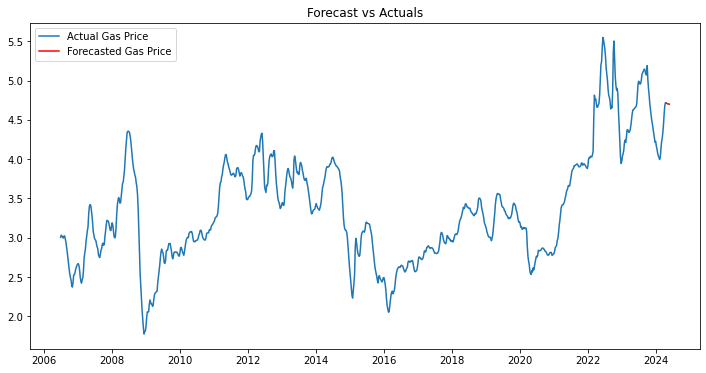

In [51]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

652 140 140


In [77]:
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

train_data = data[:split_index]
test_data = data[split_index:]

In [257]:
train_data.head()

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,...,week number,gas price,diesel_to_heating_oil_ratio,crude_oil_price_volatility_30d,crude_vs_gas_price_diff,sin_week,cos_week,supply_demand_ratio,total_import_cost,inventory_turnover
2007-01-08,56.192258,1.485742,1.709774,1.563226,1.675839,1.689226,0.909484,3863.903226,1437.967742,1.659830e+06,...,2.0,2.670,1.072039,6.333237,54.706516,0.239316,0.970942,0.855922,2.637922e+06,0.289106
2007-01-15,54.510000,1.432000,1.682000,1.528000,1.630000,1.654000,0.893000,11514.000000,1440.000000,1.652470e+06,...,3.0,2.650,1.066754,6.492661,53.078000,0.354605,0.935016,0.826311,2.555410e+06,0.298712
2007-01-22,55.587097,1.478968,1.758097,1.565258,1.659129,1.673419,0.911516,7322.806452,1445.870968,1.621081e+06,...,4.0,2.595,1.059972,6.514983,54.108129,0.464723,0.885456,0.805071,2.603754e+06,0.301247
2007-01-29,56.664194,1.525935,1.834194,1.602516,1.688258,1.692839,0.930032,3131.612903,1451.741935,1.589692e+06,...,5.0,2.503,1.053505,6.406790,55.138258,0.568065,0.822984,0.784180,2.650258e+06,0.303782
2007-02-05,57.741290,1.572903,1.910290,1.639774,1.717387,1.712258,0.948548,-1059.580645,1457.612903,1.558303e+06,...,6.0,2.449,1.047331,6.166523,56.168387,0.663123,0.748511,0.763628,2.694923e+06,0.306319


In [79]:
test_data.shape

(187, 16)

In [83]:
# Price ratios
train_data['diesel_to_heating_oil_ratio'] = train_data['diesel price'] / train_data['heating oil price']

# Historical volatility (30-day rolling standard deviation, example for crude oil price)
train_data['crude_oil_price_volatility_30d'] = train_data['crude oil price'].rolling(window=30).std()

# Price differences
train_data['crude_vs_gas_price_diff'] = train_data['crude oil price'] - train_data['conventional gas price']

# Seasonal indicators (sine and cosine transformations of week number)
train_data['sin_week'] = np.sin(2 * np.pi * train_data['week number'] / 52)
train_data['cos_week'] = np.cos(2 * np.pi * train_data['week number'] / 52)

# Supply-demand ratio
train_data['supply_demand_ratio'] = (train_data['gas production'] + train_data['gas import volume']) / train_data['gas consumption']

# Total import cost
train_data['total_import_cost'] = train_data['gas import volume'] * train_data['gas import price']

# Inventory turnover
train_data['inventory_turnover'] = train_data['gas consumption'] / train_data['gas storage']

In [125]:
# Price ratios
test_data['diesel_to_heating_oil_ratio'] = test_data['diesel price'] / test_data['heating oil price']

# Historical volatility (30-day rolling standard deviation, example for crude oil price)
test_data['crude_oil_price_volatility_30d'] = test_data['crude oil price'].rolling(window=30).std()

# Price differences
test_data['crude_vs_gas_price_diff'] = test_data['crude oil price'] - test_data['conventional gas price']

# Seasonal indicators (sine and cosine transformations of week number)
test_data['sin_week'] = np.sin(2 * np.pi * test_data['week number'] / 52)
test_data['cos_week'] = np.cos(2 * np.pi * test_data['week number'] / 52)

# Supply-demand ratio
test_data['supply_demand_ratio'] = (test_data['gas production'] + test_data['gas import volume']) / test_data['gas consumption']

# Total import cost
test_data['total_import_cost'] = test_data['gas import volume'] * test_data['gas import price']

# Inventory turnover
test_data['inventory_turnover'] = test_data['gas consumption'] / test_data['gas storage']

In [126]:
test_data.shape

(187, 24)

In [60]:
import seaborn as sns

Text(0.5, 1.0, 'Target Variable Distribution')

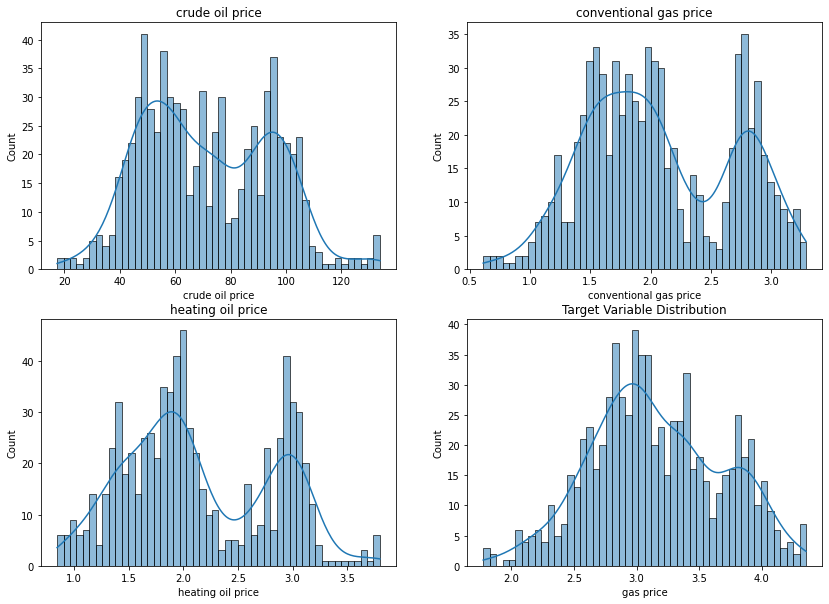

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
sns.histplot(train_data['crude oil price'], bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('crude oil price')
sns.histplot(train_data['conventional gas price'], bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('conventional gas price')
sns.histplot(train_data['heating oil price'], bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('heating oil price')
sns.histplot(train_data['gas price'], bins=50, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Target Variable Distribution')

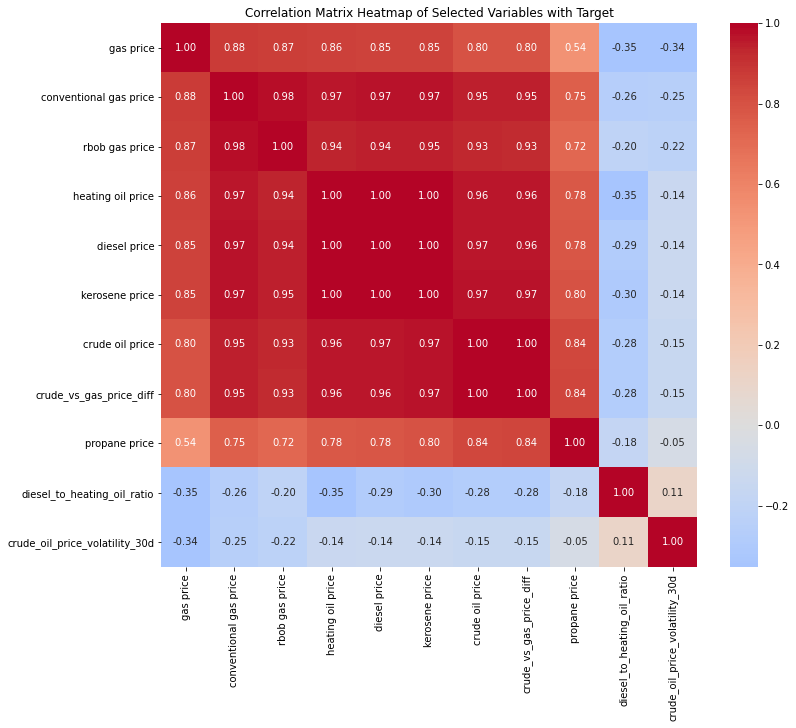

In [86]:
full_corr_matrix = train_data.corr()

# Extract correlation with 'TARGET' and sort it
target_corr = full_corr_matrix['gas price'].sort_values(key=abs, ascending=False)

# Select top N columns, including 'TARGET' itself
top_columns = target_corr.head(11).index  # Adjust the number here for more or fewer columns

# Create the correlation matrix for this subset of variables
subset_corr_matrix = train_data[top_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap of Selected Variables with Target')
plt.show()

In [87]:
correlations = train_data.corr()['gas price'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(20))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 gas import volume         -0.218305
gas consumption           -0.215263
oil stock exchange        -0.182223
sin_week                  -0.060914
total_import_cost          0.007469
gas production             0.010420
gas storage                0.043607
week number                0.044370
drilling activity          0.045187
gas import price           0.129985
supply_demand_ratio        0.238665
propane price              0.537492
crude_vs_gas_price_diff    0.796077
crude oil price            0.799173
kerosene price             0.848754
diesel price               0.852661
heating oil price          0.857969
rbob gas price             0.865915
conventional gas price     0.876052
gas price                  1.000000
Name: gas price, dtype: float64

Most Negative Correlations:
 diesel_to_heating_oil_ratio      -0.348658
crude_oil_price_volatility_30d   -0.341459
cos_week                         -0.279931
inventory_turnover               -0.242215
gas import volume

In [89]:
train_data.isnull().sum()

crude oil price                    0
conventional gas price             0
rbob gas price                     0
heating oil price                  0
diesel price                       0
kerosene price                     0
propane price                      0
oil stock exchange                 0
drilling activity                  0
gas production                     0
gas consumption                    0
gas storage                        0
gas import volume                  0
gas import price                   0
week number                        0
gas price                          0
diesel_to_heating_oil_ratio        0
crude_oil_price_volatility_30d    29
crude_vs_gas_price_diff            0
sin_week                           0
cos_week                           0
supply_demand_ratio                0
total_import_cost                  0
inventory_turnover                 0
dtype: int64

In [97]:
train_data = train_data.dropna()

In [141]:
test_data = test_data.dropna()

In [174]:
X_train = train_data.drop('gas price', axis=1)  # Drop the target variable to isolate features
Y_train = train_data['gas price']

In [142]:
X_test = test_data.drop('gas price', axis=1)  # Drop the target variable to isolate features
Y_test = test_data['gas price']

In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [131]:
forest = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
forest.fit(X_train, Y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [132]:
importances = forest.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                           Feature  Importance
1           conventional gas price    0.591694
2                   rbob gas price    0.079217
4                     diesel price    0.058199
3                heating oil price    0.039463
9                   gas production    0.036923
20             supply_demand_ratio    0.032753
11                     gas storage    0.030550
5                   kerosene price    0.030037
16  crude_oil_price_volatility_30d    0.025296
12               gas import volume    0.010815
19                        cos_week    0.008672
21               total_import_cost    0.008458
15     diesel_to_heating_oil_ratio    0.008279
10                 gas consumption    0.006770
18                        sin_week    0.004879
13                gas import price    0.004740
14                     week number    0.004620
6                    propane price    0.004259
8                drilling activity    0.004208
22              inventory_turnover    0.003743
7            

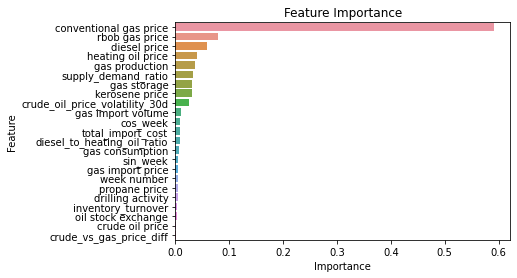

In [133]:
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [118]:
import shap

In [120]:
explainer = shap.TreeExplainer(forest)

In [137]:
shap_values = explainer.shap_values(X_test)

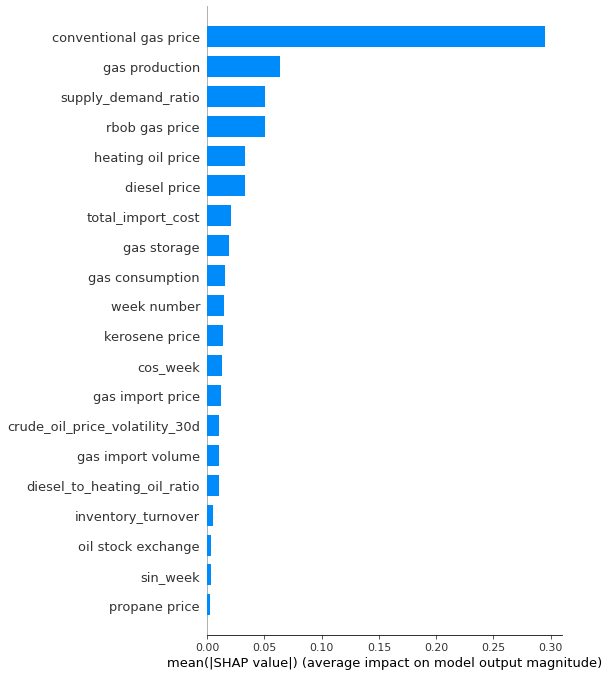

In [138]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

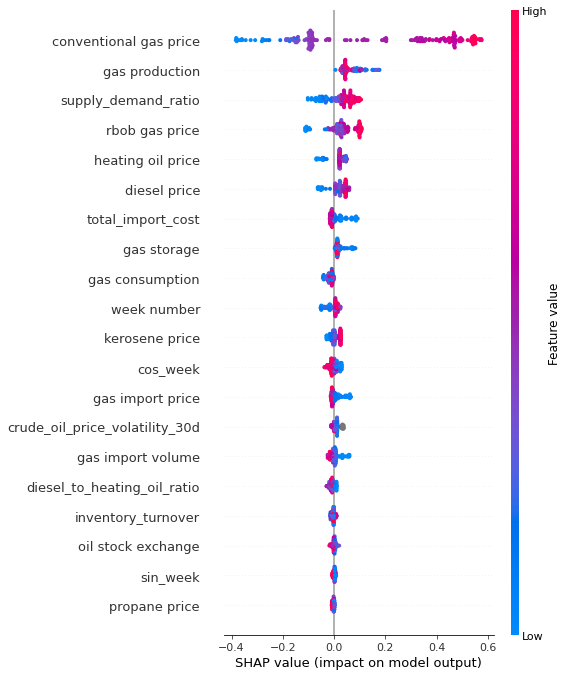

In [139]:
shap.summary_plot(shap_values, X_test)

In [107]:
from sklearn.metrics import classification_report,accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [109]:
iso = IsolationForest(n_estimators=100,max_samples=len(X_train), contamination=0.05, random_state=42)
iso.fit(X_train)

IsolationForest(contamination=0.05, max_samples=716, random_state=42)

In [175]:
outliers_train = iso.predict(X_train)

In [176]:
X_train['scores']=iso.decision_function(X_train)

In [177]:
X_train['is_outlier'] = outliers_train


# Filter out the outliers
clean_data_train = X_train[X_train['is_outlier'] != -1]

# Display results
#print("Selected Important Features:", important_feature_names)
print("Number of outliers detected:", (outliers_train == -1).sum())
print("Data shape after removing outliers:", clean_data_train.shape)

Number of outliers detected: 36
Data shape after removing outliers: (680, 25)


In [143]:
outliers_test=iso.predict(X_test)

In [144]:
#Test

X_test['scores']=iso.decision_function(X_test)
X_test['is_outlier'] = outliers_test
# Filter out the outliers
clean_data_test = X_test[X_test['is_outlier'] != -1]

print("Number of test outliers detected:", (outliers_test == -1).sum())
print("Data shape after removing outliers:", clean_data_test.shape)

Number of test outliers detected: 52
Data shape after removing outliers: (106, 25)


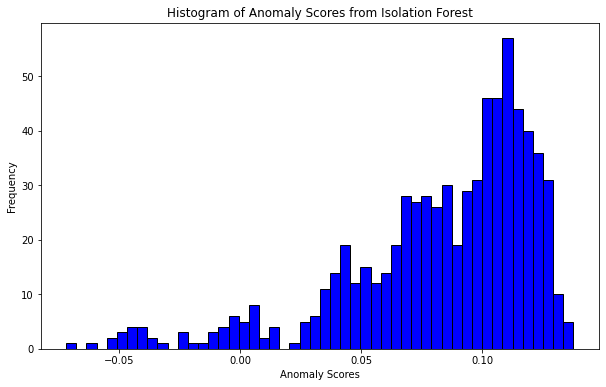

In [115]:
plt.figure(figsize=(10, 6))
plt.hist(X_train['scores'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Anomaly Scores from Isolation Forest')
plt.xlabel('Anomaly Scores')
plt.ylabel('Frequency')
plt.show()

In [149]:
X_train = X_train.dropna()

In [151]:
print(X_train['is_outlier'].isna().sum())

0


In [154]:
#for training data
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensions to 2
X_train['is_outlier'] = X_train['is_outlier'].fillna(0)
X_train = X_train.dropna(subset=['is_outlier'])
# You need to reapply PCA after dropping rows
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.drop('is_outlier', axis=1))
pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Outlier'] = X_train['is_outlier'].values  # Ensure correct alignment by using .values

In [155]:
print(pca_df['Outlier'].unique())

# Ensure all potential outlier values are handled in the colors dictionary
colors = {1: 'blue', -1: 'red', 0: 'green'}  # Added '0' for non-outliers if you used it as a fill value

[ 1 -1]


In [157]:
from matplotlib.lines import Line2D

# Define legend elements
# Ensure that you define this before using it in plt.legend()
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='red', markersize=10)
]

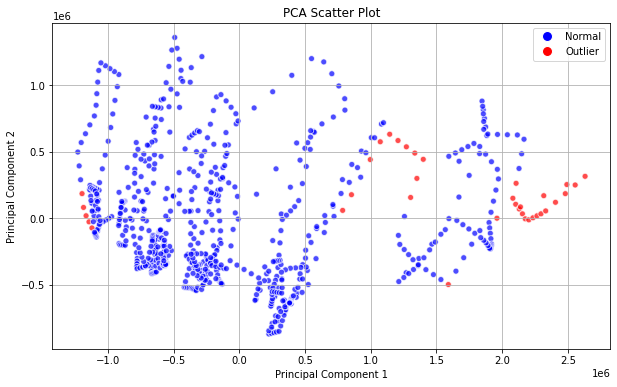

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], alpha=0.7,
                      c=pca_df['Outlier'].apply(lambda x: colors[x]),
                      edgecolors='w', marker='o')
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Adding the legend to the plot using the defined elements
plt.legend(handles=legend_elements, loc='best')

plt.show()

In [179]:
X_train_sample = X_train.drop(['scores', 'is_outlier'], axis=1)
X_test_sample = X_test.drop(['scores', 'is_outlier'], axis=1)

In [310]:
from sklearn.preprocessing import MinMaxScaler

# Assuming you have training and testing datasets as X_train and X_test
# Example initialization
# X_train = np.array([...])
# X_test = np.array([...])

# Initialize the scaler
scaler = MinMaxScaler()

# Fit on training data
scaler.fit(X_train_sample)

# Transform both train and test data with the same scaler
X_train_normalized = scaler.transform(X_train_sample)
X_test_normalized = scaler.transform(X_test_sample)

In [344]:
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train_sample.columns)

In [345]:
X_train_normalized_df

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,...,gas import price,week number,diesel_to_heating_oil_ratio,crude_oil_price_volatility_30d,crude_vs_gas_price_diff,sin_week,cos_week,supply_demand_ratio,total_import_cost,inventory_turnover
0,0.333277,0.326551,0.380629,0.243292,0.264500,0.327545,0.393275,0.420933,0.902937,0.076868,...,0.510106,0.019231,0.517802,0.148365,0.333435,0.619658,0.985471,0.145018,0.671406,0.588990
1,0.318836,0.306461,0.371900,0.231373,0.249243,0.316761,0.382757,0.522671,0.904278,0.072612,...,0.485911,0.038462,0.477313,0.153167,0.319127,0.677302,0.967508,0.106852,0.647828,0.638380
2,0.328082,0.324019,0.395817,0.243980,0.258938,0.322706,0.394571,0.466933,0.908154,0.054459,...,0.505487,0.057692,0.425352,0.153839,0.328178,0.732362,0.942728,0.079476,0.661642,0.651411
3,0.337328,0.341577,0.419734,0.256587,0.268633,0.328651,0.406386,0.411194,0.912030,0.036306,...,0.525063,0.076923,0.375807,0.150580,0.337228,0.784032,0.911492,0.052550,0.674931,0.664446
4,0.346574,0.359135,0.443652,0.269193,0.278329,0.334596,0.418200,0.355456,0.915905,0.018153,...,0.544639,0.096154,0.328513,0.143344,0.346278,0.831561,0.874255,0.026061,0.687694,0.677485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,0.207616,0.235396,0.277843,0.102718,0.104725,0.141407,0.133788,0.093469,0.000447,0.856045,...,0.040534,0.653846,0.286504,0.250591,0.206963,0.057272,0.267638,0.814363,0.028106,0.398078
712,0.202363,0.233623,0.269468,0.094238,0.096909,0.134079,0.132203,0.130454,0.000894,0.846849,...,0.043394,0.673077,0.304448,0.234199,0.201628,0.032492,0.322698,0.844098,0.025100,0.367060
713,0.197110,0.231850,0.261093,0.085757,0.089092,0.126752,0.130618,0.167438,0.001342,0.837653,...,0.046253,0.692308,0.323211,0.219131,0.196294,0.014529,0.380342,0.875328,0.021953,0.336042
714,0.191857,0.230078,0.252719,0.077276,0.081276,0.119424,0.129033,0.204423,0.001789,0.828457,...,0.049113,0.711538,0.342851,0.207493,0.190959,0.003646,0.439732,0.908170,0.018666,0.305024


In [ ]:
#Modelling

In [164]:
from xgboost import XGBRegressor

In [165]:
xgb_Reg = XGBRegressor(n_estimators=100,max_depth=5)

In [313]:
xgb_Reg.fit(X_train_normalized,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [314]:
y_pred = xgb_Reg.predict(X_test_normalized)

In [315]:
def evaluate_regression(y_true, y_pred):
    """
    Evaluate regression model performance.
    
    Parameters:
        y_true (array-like): True values of the target variable.
        y_pred (array-like): Predicted values from the regression model.
    
    Returns:
        dict: A dictionary containing MAE, MSE, RMSE, and R² metrics.
    """
    metrics = {}
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['R_squared'] = r2_score(y_true, y_pred)
    
    return metrics

In [316]:
df = pd.DataFrame(Y_test)

In [317]:
df_reset = df.reset_index(drop=True)

In [318]:
gas_price = pd.Series(df_reset['gas price'])

In [319]:
Final = pd.DataFrame({
    'Gas Price': gas_price,
    'Predicted': y_pred
})

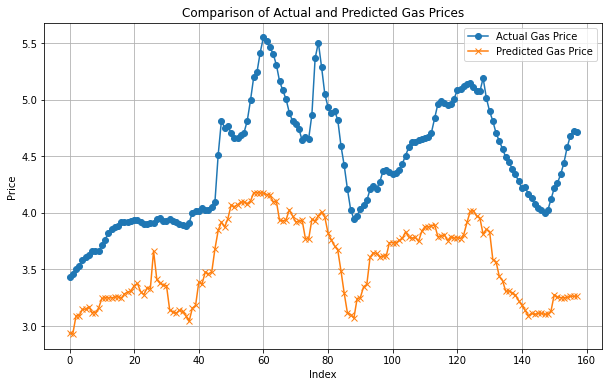

In [320]:
import matplotlib.pyplot as plt

# Assuming 'Final' DataFrame is already created and contains 'Gas Price' and 'Predicted' columns
plt.figure(figsize=(10, 6))
plt.plot(Final['Gas Price'], label='Actual Gas Price', marker='o')
plt.plot(Final['Predicted'], label='Predicted Gas Price', marker='x')
plt.title('Comparison of Actual and Predicted Gas Prices')
plt.xlabel('Index')  # Adjust if you have a specific x-axis such as dates
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [321]:
Metrics_xgb=evaluate_regression(Final['Gas Price'],Final['Predicted'])

In [322]:
Metrics_xgb

{'MAE': 0.880703163810923,
 'MSE': 0.8541413503606837,
 'RMSE': 0.9241976792660127,
 'R_squared': -2.242499041836511}

In [226]:
xgb_regressor_updated = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',  # Change to a regression objective
    n_jobs=-1,
    reg_lambda=1.0,
    reg_alpha=0.1,
    eval_metric='rmse',  # Change to a regression metric
    random_state=42
)

In [242]:
xgb_regressor_updated.fit(X_train_normalized,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.1, reg_lambda=1.0, ...)

In [243]:
y_pred_updated = xgb_regressor_updated.predict(X_test_normalized)

In [244]:
Metrics_xgbUpdated=evaluate_regression(Final['Gas Price'],y_pred_updated)

In [245]:
Metrics_xgbUpdated

{'MAE': 0.9062071040310435,
 'MSE': 0.8988320116507622,
 'RMSE': 0.948067514289337,
 'R_squared': -2.4121541303659773}

In [246]:
y_pred_updated

array([2.9932764, 2.9879067, 3.0761917, 3.0952559, 3.1372364, 3.139951 ,
       3.1460764, 3.165485 , 3.1695085, 3.223486 , 3.2507668, 3.240834 ,
       3.2486942, 3.2412853, 3.2386556, 3.2409499, 3.2384279, 3.2390742,
       3.2365422, 3.223698 , 3.2123983, 3.2002108, 3.2527406, 3.269139 ,
       3.3587096, 3.4536576, 3.522761 , 3.4275653, 3.433856 , 3.3500617,
       3.2852082, 3.2572498, 3.1703439, 3.130347 , 3.1265042, 3.134051 ,
       3.1228237, 3.1408648, 3.1940343, 3.2425187, 3.3052115, 3.3352704,
       3.4011285, 3.4036188, 3.5408206, 3.6752884, 3.7797754, 3.8178036,
       3.8543663, 3.934742 , 3.9179626, 3.918309 , 3.9143138, 3.9631653,
       3.956486 , 3.9498692, 3.9657097, 4.0049105, 4.0049105, 4.002721 ,
       4.0021424, 4.001709 , 4.0057654, 3.9656708, 3.9622986, 3.911388 ,
       3.9141319, 3.9141319, 3.913051 , 3.9130414, 3.8828547, 3.8523924,
       3.8500123, 3.8193839, 3.8193839, 3.8503265, 3.8738377, 3.925435 ,
       3.9220963, 3.827617 , 3.7953064, 3.6403117, 